In [3]:

import pandas as pd
import pickle
import networkx as nx
import sys
import os

sys.path.append(os.path.abspath('..'))
from src.features import get_pagerank, get_approx_betweenness, get_clustering_coefficient, get_harmonic_centrality

from src import load_or_compute

# 1. Load the graph from the pickle file
# Make sure the path is correct relative to where you run this script
with open("../data/processed/amazon_graph.pickle", "rb") as f:
    G_loaded = pickle.load(f)

recompute = False

In [4]:
# 2. Pass the LOADED graph object to the function
pagerank_scores = get_pagerank(G_loaded,0.9)


df_pagerank = pd.DataFrame(list(pagerank_scores.items()), columns=['ASIN', 'PageRank'])
display(df_pagerank.head(5))
# Save to CSV
df_pagerank.to_csv("../data/processed/pagerank_scores.csv", index=False)


# Now you can use the scores
print(f"Computed PageRank for {len(pagerank_scores)} nodes.")

Calcolo PageRank su 334843 nodi...


,ASIN,PageRank
0,0827229534,8.386325e-06
1,0738700797,8.178738e-06
2,0842328327,6.473884e-07
3,1577943082,1.558228e-06
4,0486220125,3.262809e-07


Computed PageRank for 334843 nodes.


In [6]:
%run myPagerank.ipynb

df_handpagerank = load_or_compute("../data/processed/handpagerank_scores.csv",get_prscores, recompute,graph_obj = G_loaded)
# Now all functions (build_index_map, calculate_pagerank, etc.) are available in memory
#prscores = get_prscores(G_loaded)
display(sum(df_handpagerank["handpagerank"].values))
#df_handpagerank = pd.DataFrame(list(prscores.items()), columns=['ASIN', 'MyHandPageRank'])
#display(df_handpagerank.head(20))
# Save to CSV
#df_handpagerank.to_csv("../data/processed/handpagerank_scores.csv", index=False)

cpu
File found.


np.float64(0.9854412932845537)

In [10]:


df_bet = load_or_compute("../data/processed/bet_scores.csv",get_approx_betweenness,recompute,G=G_loaded,k=1000) 
display(df_bet.head(5))
# Save to CSV



# Now you can use the scores
print(f"Computed bet cent for {len(df_bet)} nodes.")

File found.


,Betweenness
ASIN,
0827229534,5.321799e-05
0738700797,6.280827e-09
0842328327,0.000000e+00
1577943082,0.000000e+00
0486220125,0.000000e+00


Computed bet cent for 334843 nodes.


In [11]:


df_clus = load_or_compute("../data/processed/clus_scores.csv",get_clustering_coefficient,recompute,G = G_loaded)
display(df_clus.head(5))

# Now you can use the scores
print(f"Computed cc for {len(df_bet)} nodes.")

File found.


,ClusteringCoefficient
ASIN,
0827229534,0.290323
0738700797,0.563953
0842328327,0.400000
1577943082,0.888889
0486220125,0.333333


Computed cc for 334843 nodes.


In [14]:
# Compute Harmonic scores and save them to a csv file
df_harmonic_scores = load_or_compute("../data/processed/harm_scores.csv",get_harmonic_centrality,recompute,G= G_loaded, version="GPU")
#df_harmonic_scores.to_csv("../data/processed/harm_scores.csv", index=False)

display(df_harmonic_scores.head(5))
print(f"Computed hc for {len(df_harmonic_scores)} nodes.")

File found.


,HarmonicCentrality
ASIN,
0827229534,10890.978000
0738700797,9056.977000
0842328327,2.840921
1577943082,5.111011
0486220125,0.000000


Computed hc for 334843 nodes.


### Now we work on df


In [16]:

#df_pagerank = pd.DataFrame.from_dict(pagerank_scores, orient='index', columns=['PageRank'])
#df_clus = pd.DataFrame.from_dict(clus_scores, orient='index', columns=['ClusteringCoeff'])
#df_bet = pd.DataFrame.from_dict(bet_scores, orient='index', columns=['Betweenness'])


data_frames = [df_handpagerank,df_clus,df_bet,df_harmonic_scores]

df_final = pd.concat(data_frames,axis=1)



In [17]:

salesrank_dict = nx.get_node_attributes(G_loaded, 'salesrank')

# 2. Convert to DataFrame
df_salesrank = pd.DataFrame.from_dict(salesrank_dict, orient='index', columns=['salesrank'])
df_salesrank.index.name = 'ASIN'

# 3. Join to df_final
# This performs a left join on the index (ASIN)
df_final = df_final.join(df_salesrank)

# Check the result
display(df_final.head())

,handpagerank,ClusteringCoefficient,Betweenness,HarmonicCentrality,salesrank
ASIN,,,,,
0827229534,5.332977e-06,0.290323,5.321799e-05,10890.978000,396585.0
0738700797,9.438284e-06,0.563953,6.280827e-09,9056.977000,168596.0
0842328327,6.925232e-07,0.400000,0.000000e+00,2.840921,631289.0
1577943082,1.400741e-06,0.888889,0.000000e+00,5.111011,455160.0
0486220125,4.671820e-07,0.333333,0.000000e+00,0.000000,188784.0


In [18]:
df_final.to_csv("../data/processed/structural_metrics.csv")

## Clustering

In [20]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

features = ['handpagerank','Betweenness','ClusteringCoefficient','HarmonicCentrality','salesrank']
X=df_final[features]

#non ci dovrebbero essere NaN ma per sicurezza
X=X.fillna(0)

In [ ]:
X.head()

,PageRank,Betweenness,ClusteringCoefficient,HarmonicCentrality,salesrank
ASIN,,,,,
0827229534,8.386325e-06,5.321784e-05,0.290323,0.290323,396585.0
0738700797,8.178738e-06,6.280808e-09,0.563953,0.563953,168596.0
0842328327,6.473884e-07,0.000000e+00,0.400000,0.400000,631289.0
1577943082,1.558228e-06,0.000000e+00,0.888889,0.888889,455160.0
0486220125,3.262809e-07,0.000000e+00,0.333333,0.333333,188784.0


Standardize

In [21]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4)
clusters = kmeans.fit_predict(X_scaled)

df_final['cluster_kmeans']= clusters

#questo stampa quanti nodi per ogni gruppo
print(df_final['cluster_kmeans'].value_counts())

#maybe we can save it

cluster_kmeans
1    150241
0     95612
2     85701
3      3289
Name: count, dtype: int64


confronto con gruppi 

In [22]:
#aggiungo il gruppo 
groups_dict = nx.get_node_attributes(G_loaded, 'group')

# 2. Converti in un DataFrame (assicurandoti che l'indice sia l'ASIN)
df_groups = pd.DataFrame.from_dict(groups_dict, orient='index', columns=['group'])
df_groups.index.name = 'ASIN'

# 3. Unisci al tuo df_final
# join è intelligente: allinea automaticamente gli indici (ASIN)
df_final = df_final.join(df_groups)

In [23]:
import seaborn as sns 
import matplotlib.pyplot as plt

crosstab = pd.crosstab(df_final['cluster_kmeans'], df_final['group'])

print(crosstab)

group             Book   DVD  Music  Video
cluster_kmeans                            
0                67011  3360  19255   5986
1               113005  7270  21918   8048
2                66361  4730  13297   1313
3                 2539   383    354     13


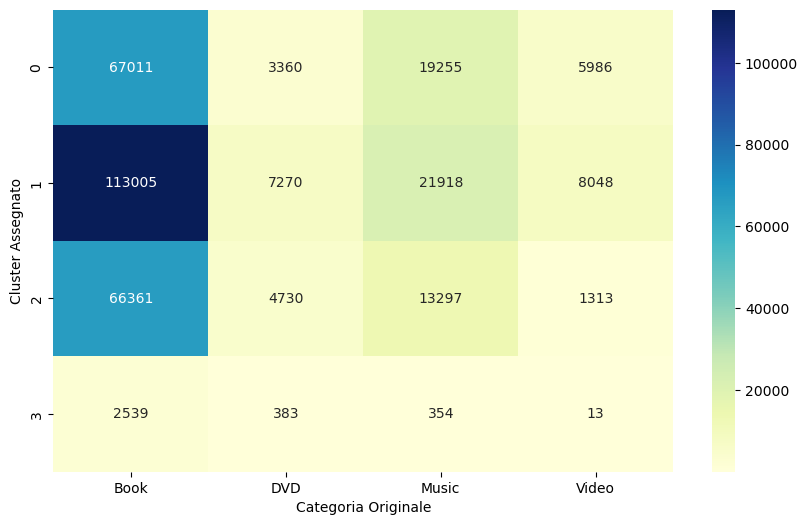

In [24]:
plt.figure(figsize=(10,6))
sns.heatmap(crosstab, annot=True, fmt='d',cmap='YlGnBu')
plt.xlabel('Categoria Originale')
plt.ylabel('Cluster Assegnato')
plt.show()